<a href="https://colab.research.google.com/github/hrishikavachhani/nlp/blob/master/NLP_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

dataset = pd.read_csv('/content/housing.csv')
dataset = dataset.dropna()
dataset.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


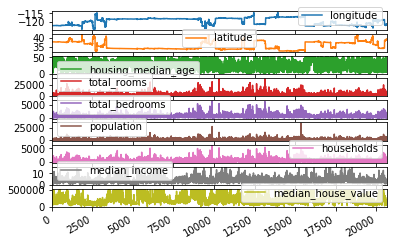

In [4]:
df = pd.DataFrame(dataset)
df.plot(subplots=True)

In [0]:
Y=dataset['median_house_value']
X=dataset.loc[:,'longitude':'median_income']

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
x_train_np=x_train.to_numpy()
y_train_np=y_train.to_numpy()

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu

from torch.utils.data import DataLoader,TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module):
    def __init__(self, batch_size, inputs, outputs):
        super(CnnRegressor, self).__init__()
        self.batch_size=batch_size
        self.inputs=inputs
        self.outputs=outputs

        self.input_layer=Conv1d(inputs, batch_size,1)
        self.max_pooling_layer=MaxPool1d(1)
        self.conv_layer=Conv1d(batch_size,128,1)
        self.flatten_layer=Flatten()
        self.linear_layer=Linear(128,64)
        self.output_layer= Linear(64,outputs)

    def feed(self,input):
        input=input.reshape((self.batch_size,self.inputs,1))

        output=relu(self.input_layer(input))
        output=self.max_pooling_layer(output)
        output=relu(self.conv_layer(output))
        output=self.flatten_layer(output)
        output=self.linear_layer(output)
        output=self.output_layer(output)
        return output

In [10]:
from torch.optim import SGD
from torch.nn import L1Loss

!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 2.7MB/s 


In [11]:
batch_size=64
model= CnnRegressor(batch_size, X.shape[1],1)

model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model,dataset,train=False,optimizer=None):
  performance=L1Loss()
  score_metric= R2Score()

  avg_loss=0
  avg_score=0
  count=0
  for input,output in iter(dataset):
    predictions=model.feed(input)
    loss=performance(predictions,output)

    score_metric.update([predictions,output])
    score=score_metric.compute()

    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    avg_loss+=loss.item()
    avg_score+=score
    count+=1
  return avg_loss/count,avg_score/count

In [13]:
epochs=200
optimizer= SGD(model.parameters(),lr=1e-5)

inputs=torch.from_numpy(x_train_np).cuda().float()
outputs=torch.from_numpy(y_train_np.reshape(
    y_train_np.shape[0],1)).cuda().float()
tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)

for epoch in range(epochs):
  avg_loss, avg_r2_score=model_loss(
      model,loader,train=True, optimizer=optimizer)
  print("Epoch"+str(epoch+1)+":\n\tLoss="+str(
      avg_loss)+"\n\tR^2 Score="+str(avg_r2_score))

Epoch1:
	Loss=131024.26770833334
	R^2 Score=-1.961252126376993
Epoch2:
	Loss=117294.67239583333
	R^2 Score=-1.109191433208816
Epoch3:
	Loss=114560.59243259804
	R^2 Score=-1.0060780486590981
Epoch4:
	Loss=111933.13446691177
	R^2 Score=-0.790609370040694
Epoch5:
	Loss=107129.35110294117
	R^2 Score=-0.7088962701789387
Epoch6:
	Loss=104010.20490196078
	R^2 Score=-0.6459816201858992
Epoch7:
	Loss=102005.09917279411
	R^2 Score=-0.548723583859607
Epoch8:
	Loss=101451.940625
	R^2 Score=-0.4910084607732681
Epoch9:
	Loss=97022.47481617647
	R^2 Score=-0.4169022297579361
Epoch10:
	Loss=96189.86864276961
	R^2 Score=-0.27565416148178673
Epoch11:
	Loss=93217.99361213236
	R^2 Score=-0.1764914071526963
Epoch12:
	Loss=93807.88213848039
	R^2 Score=-0.17055362182283268
Epoch13:
	Loss=91276.9378370098
	R^2 Score=-0.11331348881209018
Epoch14:
	Loss=92342.10733762255
	R^2 Score=-0.18113249303866988
Epoch15:
	Loss=90570.96703431373
	R^2 Score=-0.0705264380487841
Epoch16:
	Loss=89729.3997242647
	R^2 Score=-0.0

In [14]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs=torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()
tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)

avg_loss,avg_r2_score=model_loss(model,loader)
print("The model's L1 Loss is: "+str(avg_loss))
print("The model's R^2 Loss is: "+str(avg_r2_score))

The model's L1 Loss is: 72495.18520585318
The model's R^2 Loss is: 0.3404036999719282


In [16]:
torch.save(model, '1111692_1dconv_reg.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
